### *Цель работы*

-----

<br>
Провести предобработку и разведочный анализ выборки клиентов (файл clients.csv).
Используя данные о выборке, построить типичный портрет целевого клиента компании с соответствующими визуализациями и статистическими выводами(пол, возраст, какой тип квартиры он приобретает, какова площадь в кв. м , каков средний чек, цель покупки, источник лида (за это отвечает колонка Source). Таким образом после вашего анализа, я хочу увидеть небольшое описание нашего целевого клиента с соответствующими визуализациями и статистическими выводами, что мы и прошли с вами на лекции.

<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import phik
from scipy import stats
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

In [15]:
data = pd.read_csv("./clients.csv", parse_dates={'sale_date': [2,3]})

# **Очистка и подготовка данных**
Прежде чем переходить к процессу очистки, всегда нужно представлять исходный датасет. Давайте быстро взглянем на сами данные:

In [17]:
pd.set_option('display.max_columns', None)
data.head()

,sale_date,ID,Building,Type of property,Property number,Area (ft.),Price,Status,Customer ID,Entity,Name,Surname,Age at time of purchase,Age Interval,Y,M,D,Gender,Country,State,Purpose,Deal satisfaction,Mortgage,Source
0,2005-11-01,1030,1,Apartment,30,743.09,"$ 246,172.68",Sold,C0028,Individual,Madalyn,Mercer,19.0,18-25,1986.0,6.0,21.0,F,USA,California,Home,5,No,Website
1,2005-10-01,1029,1,Apartment,29,756.21,"$ 246,331.90",Sold,C0027,Individual,Lara,Carrillo,22.0,18-25,1983.0,2.0,24.0,F,USA,California,Home,5,No,Website
2,2007-07-01,2002,2,Apartment,2,587.28,"$ 209,280.91",Sold,C0112,Individual,Donavan,Flowers,22.0,18-25,1985.0,12.0,27.0,M,USA,California,Home,1,Yes,Client
3,2007-12-01,2031,2,Apartment,31,1604.75,"$ 452,667.01",Sold,C0160,Individual,Darien,Dorsey,22.0,18-25,1985.0,12.0,27.0,M,USA,California,Investment,3,Yes,Website
4,2004-11-01,1049,1,Apartment,49,1375.45,"$ 467,083.31",Sold,C0014,Individual,Alessandra,Perry,25.0,18-25,1979.0,5.0,15.0,F,USA,California,Home,4,No,Agency


In [ ]:
data.Status.value_counts()

 Sold     195
Name: Status, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   sale_date                195 non-null    datetime64[ns]
 1   ID                       195 non-null    int64         
 2   Building                 195 non-null    int64         
 3   Type of property         195 non-null    object        
 4   Property number          195 non-null    int64         
 5   Area (ft.)               195 non-null    float64       
 6   Price                    195 non-null    object        
 7   Status                   195 non-null    object        
 8   Customer ID              195 non-null    object        
 9   Entity                   195 non-null    object        
 10  Name                     195 non-null    object        
 11  Surname                  195 non-null    object        
 12  Age at time of purchase  178 non-nul

# **Очистка и подготовка данных**

# **Вывод 1:**
В датасете есть колонки, дублирующие информацию, их необходимо удалить.
Колонки Y, M, D дублирую информацию о возрасте покупателя - Age at time of purchase.
Есть колонки, которые не представляют большого инетерса для исследования - это 'Name', 'Surname', 'id','property_number','status' (т.к. мы убедились в том, что статус почти везде одинаковый). В данных есть 'Customer ID', для анализа повторных покупок одним и тем же клиентом этого вполне достаточно. Удалим и эти колонки.

In [18]:
# Удалим ненужные колонки
data.drop(['Y', 'M', 'D', 'Name','Surname','ID','Property number','Status' ], axis = 1, inplace= True)

In [19]:
# Переименуем колонки, чтобы было легче к ним обращаться через точку.
data = data.rename(columns=lambda val: val.replace(" ", "_").lower())

Поработаем над форматом колонки **price**

In [20]:
data.price = data.price.str.replace('$','').str.replace(',','')

In [41]:
data['price'] = data['price'].astype('float64')

# **Отсутствующие данные**

In [21]:
#Расчет пропусков в процентах
pd.DataFrame(data.isnull().sum()/len(data)*100, columns = ['Количество пропусков (%)'])

,Количество пропусков (%)
sale_date,0.000000
building,0.000000
type_of_property,0.000000
area_(ft.),0.000000
price,0.000000
customer_id,0.000000
entity,0.000000
age_at_time_of_purchase,8.717949
age_interval_,8.717949
gender,8.717949


<Axes: >

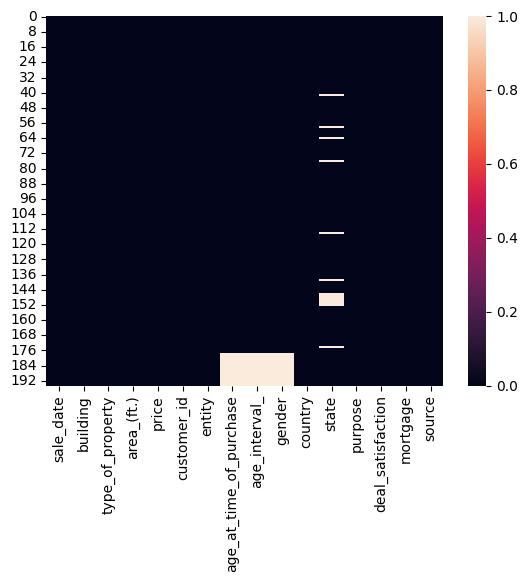

In [ ]:
sns.heatmap(data.isnull())

Пропущенных значений не очень много, удалять никакие колонки целиком не нужно, самым оптимальным будет заполнить недостающие данные колонок age_interval  самым распространенным значением, а именно модой. Сначала найдем самое распространенное значение интервала возраста, потом заполним возраст так, чтобы он соответсвовал интервалу но был максимально близко к моде колонки age_at_time_of_purchase. По графику heatmap видно, что все эти данные отсутствуют у одних и тех же клиентов.

In [22]:
data.age_at_time_of_purchase.mode()[0]

48.0

In [24]:
data.age_interval_.mode()[0]

'36-45'

In [25]:
# Соответсвенно, заполняем недостающие данные интревалом 36-45, а возраст 45 годами
data.age_interval_ = data.age_interval_.fillna(data.age_interval_.mode()[0])
data.age_at_time_of_purchase = data.age_at_time_of_purchase.fillna(45)

**Для заполнения колонки gender** можно было посмотреть, имеет ли значительную корреляцию с другими признаками, для того, чтобы наиболее корректно ее заполнить в соответствии с данными в коррелирующих колонках. Для этого можно использовать  удобную библиотеку Phi_K Correlation Analyzer Library, которая позволяет без лишних действий посмотреть корреляции категориальных переменных.

In [31]:
# Составим матрицу корреляции
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['building', 'area_(ft.)', 'age_at_time_of_purchase', 'deal_satisfaction']


,sale_date,building,type_of_property,area_(ft.),price,customer_id,entity,age_at_time_of_purchase,age_interval_,gender,country,state,purpose,deal_satisfaction,mortgage,source
sale_date,1.00,0.87,0.77,0.46,1.00,1.00,0.92,0.76,0.73,0.29,0.67,0.00,0.55,0.62,0.41,0.55
building,0.87,1.00,0.26,0.25,1.00,0.99,0.37,0.35,0.22,0.03,0.20,0.25,0.13,0.16,0.00,0.27
type_of_property,0.77,0.26,1.00,0.27,1.00,0.89,0.55,0.18,0.20,0.00,0.00,0.14,0.22,0.08,0.05,0.00
area_(ft.),0.46,0.25,0.27,1.00,0.44,0.91,0.00,0.21,0.11,0.00,0.14,0.09,0.36,0.00,0.00,0.22
price,1.00,1.00,1.00,0.44,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.86,1.00,0.85
customer_id,1.00,0.99,0.89,0.91,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.98,1.00,0.98
entity,0.92,0.37,0.55,0.00,1.00,1.00,1.00,0.72,0.54,NaN,0.58,0.08,0.49,0.19,0.00,0.11
age_at_time_of_purchase,0.76,0.35,0.18,0.21,1.00,1.00,0.72,1.00,0.96,0.00,0.48,0.41,0.36,0.23,0.00,0.26
age_interval_,0.73,0.22,0.20,0.11,1.00,1.00,0.54,0.96,1.00,0.00,0.36,0.25,0.21,0.10,0.00,0.28
gender,0.29,0.03,0.00,0.00,0.00,1.00,NaN,0.00,0.00,1.00,0.13,0.00,0.00,0.06,0.16,0.00


In [8]:
data['gender'].value_counts()

M    108
F     70
Name: gender, dtype: int64

Как видим по матрице, 'gender' не имеет сильной корреляции ни с одной из колонок, распределение значений перекошено в сторону male. Чтобы не перекашивать выборку еще больше, было принято решение заполнить эти данные случайно выбранным значением из столбца.

In [32]:
data.gender.fillna(random.choice(data.gender[data.gender.notna()]), inplace=True)

Посмотрим на значения колонки Country и избавимся от пробелов в заполнении оснойвной страны USA. Также. чтобы не было пропущенных значений, заполним колонку State значением 'Not USA'.

In [ ]:
data['country'].value_counts()

USA        165
USA         12
Canada       7
Russia       4
UK           2
Belgium      2
Denmark      1
Germany      1
Mexico       1
Name: country, dtype: int64

In [11]:
data['country'] = data.country.apply(lambda x:x.strip())
data['country'].value_counts()

USA        177
Canada       7
Russia       4
UK           2
Belgium      2
Denmark      1
Germany      1
Mexico       1
Name: country, dtype: int64

In [12]:
data.state.fillna('Not USA', inplace=True)
data['state'].value_counts()

California    119
Nevada         17
Not USA        14
Arizona        11
Oregon         11
Colorado       11
Utah            6
Virginia        4
Kansas          1
Wyoming         1
Name: state, dtype: int64

# **Работа с выбросами**
Посмотрим на данные статистики, чтобы понять, имеют ли данные выбросы

In [42]:
pd.set_option('display.float_format', '{:.3f}'.format)
data.describe()

,building,area_(ft.),price,age_at_time_of_purchase,deal_satisfaction
count,195.000,195.000,195.000,195.000,195.000
mean,2.564,899.867,269434.561,46.051,3.605
std,1.243,261.490,80129.094,12.270,1.363
min,1.000,410.710,117564.070,19.000,1.000
25%,2.000,739.860,212393.250,37.500,3.000
50%,2.000,785.480,243052.590,45.000,4.000
75%,3.000,1075.460,308550.875,55.000,5.000
max,5.000,1942.500,529317.280,76.000,5.000


Похоже, что у нас есть выброс(ы) в колонках area_(ft.) и price. Визуализируем данные в этих колонках

In [45]:
# воспользуемся функцией histogram()
px.histogram(data, # передав ей датафрейм,
             x = 'price', # конкретный столбец для построения данных,
             nbins = 10, # количество интервалов в гистограмме
             marginal = 'box') # и тип дополнительного графика

In [46]:
#  воспользуемся функцией histogram()
px.histogram(data, # передав ей датафрейм,
             x = 'area_(ft.)', # конкретный столбец для построения данных,
             nbins = 10, # количество интервалов в гистограмме
             marginal = 'box') # и тип дополнительного графика

Удалим выбросы в этих колонках с помощью Z-score.

In [47]:
data = data[(np.abs(stats.zscore(data['area_(ft.)'])) < 3)]
data = data[(np.abs(stats.zscore(data['price'])) < 3)]

In [48]:
data.describe(include=np.object)

,type_of_property,customer_id,entity,age_interval_,gender,country,state,purpose,mortgage,source
count,193,193,193,193,193,193,179,193,193,193
unique,2,160,2,6,2,9,9,2,2,3
top,Apartment,C0174,Individual,36-45,M,USA,California,Home,No,Website
freq,186,9,177,68,123,163,117,118,132,117


# **Проведем сегментацию клиентов для выявления типичных групп целевых клиентов известными нам методами (кластеризацией K-средних).**



Предобработка данных для алгоритма k-means:
1. Необходимо стандартизировать числовые колонки, которые будут участвовать в процессе кластеризации - это колонки 'area_(ft.)', 'price' ,'age_at_time_of_purchase'.
2. Необходимо закодировать нечисловые признаки, которые будут участвовать в процессе кластеризации - это колонки 'building', 'type_of_property', 'entity','age_interval_','gender','state','purpose','source','deal_satisfaction'

In [49]:
# Проведем стандартизацию данных
col_names = ['area_(ft.)', 'price' ,'age_at_time_of_purchase','deal_satisfaction']
features = data[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,area_(ft.),price,age_at_time_of_purchase,deal_satisfaction
0,-0.601,-0.272,-2.223,1.037
1,-0.547,-0.269,-1.978,1.037
2,-1.235,-0.755,-1.978,-1.906
3,2.904,2.437,-1.978,-0.435
4,1.971,2.626,-1.732,0.301


In [51]:
obj_col = ['building', 'type_of_property', 'entity','age_interval_','gender','state','purpose','source']
obj_df = data[obj_col]
obj_df = pd.get_dummies(obj_df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

Объединим данные в один датафрейм и визуализируем производительность модели кластеризации на графике изгиба.

Диаграмма изгиба подскажет нам идеальное количество кластеров для использования при построении нашей модели.

In [52]:
newdf =pd.concat([scaled_features.reset_index(),obj_df.reset_index()],axis=1, join="inner")


Text(0, 0.5, 'Inertia')

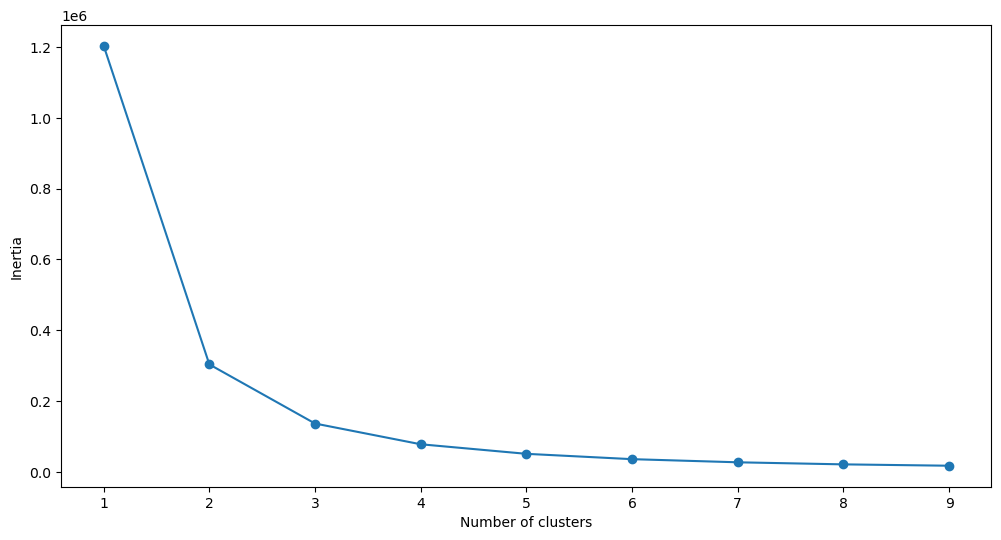

In [53]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)


frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Можно считать, что хорошее количество - это 2 или 3. Для того, чтобы определиться, нужно уточнить еще одну метрику.
Коэффициент силуэта или показатель силуэта - это показатель, используемый для оценки качества кластеров, созданных алгоритмом.

Баллы за силуэт варьируются от -1 до +1. Чем выше оценка силуэта, тем лучше модель.
Оценка силуэта измеряет расстояние между всеми точками данных в одном кластере. Чем меньше это расстояние, тем лучше оценка силуэта.
Он также измеряет расстояние между объектом и точками данных в ближайшем кластере. Чем выше это расстояние, тем лучше.
Оценка силуэта ближе к +1 указывает на хорошую производительность кластеризации, а оценка силуэта ближе к -1 указывает на плохую модель кластеризации.
Давайте посчитаем оценку силуэта только что построенной модели:

In [54]:
kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(newdf)
print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.5780193554831404


# **Построение модели кластеризации # 2**
Для этой модели давайте сожмем признаковое пространство методом главных компонентов (PCA).
PCA - это метод, который помогает нам уменьшить размер набора данных. Когда мы запускаем PCA для фрейма данных, создаются новые компоненты. Эти компоненты объясняют максимальную дисперсию модели. Необходимое количество компонент PCA можно выяснить по графику осыпи.
Мы можем выбрать подмножество этих переменных и включить их в модель K-средних.

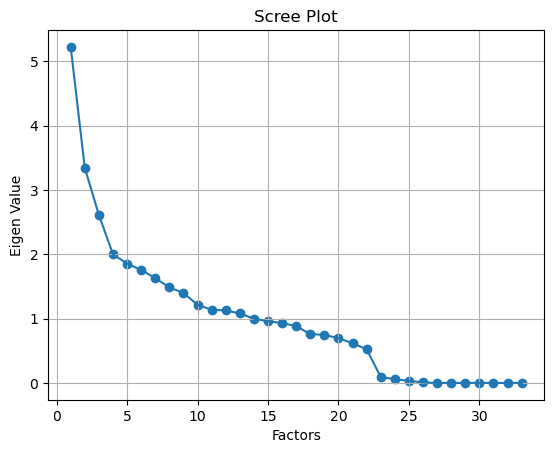

In [56]:
#ШРассчет собсвтенных чисел (PCA)

x = np.array(newdf)
scaler = StandardScaler()
x = scaler.fit_transform(x)
ev, _ = np.linalg.eig(np.cov(x.T))
ev = np.sort(ev)[::-1]
plt.scatter(range(1,newdf.shape[1]+1),ev)
plt.plot(range(1,newdf.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()

Необходимое количество признаков находится на графике до значения Eigen Value равным единице. В нашем случае - это 14 признаков.

In [57]:
pd.set_option('display.float_format', '{:.2f}'.format)
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(newdf)
PCA_components = pd.DataFrame(principalComponents)

Снова построим график осыпи для определения количества кластеров.

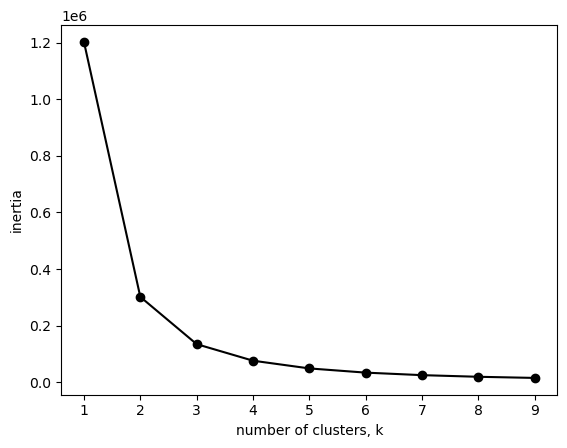

In [58]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Оптимальное количество кластеров составляет 3.

Мы можем рассчитать оценку силуэта для этой модели с 3 кластерами:

In [46]:
model = KMeans(n_clusters=3)
model.fit(PCA_components.iloc[:,:2])
# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'))

0.5819105183451145


Оценка силуэта этой модели составляет 0,582, что чуть лучше, чем у предыдущей модели, при этом мы значительно сократили признаковое пространство.
По этим причинам мы можем выбрать вторую модель, чтобы продолжить наш анализ.
#
# **Кластерный анализ**
Теперь, когда мы закончили построение этих различных кластеров, давайте попробуем интерпретировать их и взглянуть на различные сегменты клиентов.

Во-первых, давайте сопоставим кластеры с набором данных и взглянем на количественное распределение клиентов по классам.

In [59]:
data['Cluster'] = kmeans.labels_

In [60]:
data_Kmean = pd.DataFrame(data.groupby('Cluster').size(), columns = ['Количество объектов в кластере'])
data_Kmean

,Количество объектов в кластере
Cluster,
0,65
1,64
2,64


Итак, мы получили 3 группы клиентов (сегмента), почти равных по своему размеру. Причем качество разденения (обособленности) классов достаточно высокое, судя по коэффициенту силуэта.

Посмотрим на распределение данных по всем признакам в наших сегментах и сформулируем выводы откносительно характеристик каждого сегмента.

In [70]:
data.groupby(['Cluster'], as_index=False).mean()

,Cluster,building,area_(ft.),price,age_at_time_of_purchase,deal_satisfaction
0,0,2.62,940.25,284164.05,33.25,3.28
1,1,2.34,838.10,253788.01,58.17,3.95
2,2,2.77,893.32,262399.00,47.27,3.55


Посмотрим на гендерную разбивку

In [71]:
pd.DataFrame(data.groupby(['Cluster','gender'])['gender'].count())

gender
Cluster gender        
0       F           31
        M           34
1       F           17
        M           47
2       F           22
        M           42

In [72]:
pd.DataFrame(data.groupby(['Cluster','age_interval_'])['age_interval_'].count())

age_interval_
Cluster age_interval_               
0       18-25                      5
        26-35                     35
        36-45                     25
1       36-45                     16
        46-55                      4
        56-65                     26
        65+                       18
2       36-45                     27
        46-55                     37

In [73]:
pd.DataFrame(data.groupby(['Cluster','purpose'])['purpose'].count())

purpose
Cluster purpose            
0       Home             48
        Investment       17
1       Home             25
        Investment       39
2       Home             45
        Investment       19

In [74]:
pd.DataFrame(data.groupby(['Cluster','type_of_property'])['type_of_property'].count())

type_of_property
Cluster type_of_property                  
0       Apartment                       64
        Office                           1
1       Apartment                       58
        Office                           6
2       Apartment                       64

In [75]:
pd.DataFrame(data.groupby(['Cluster','state'])['state'].count())

state
Cluster state            
0       Arizona         6
        California     37
        Colorado        6
        Kansas          1
        Nevada          5
        Oregon          2
        Utah            2
        Virginia        3
1       Arizona         3
        California     33
        Colorado        1
        Nevada          8
        Oregon          6
        Utah            2
        Virginia        1
        Wyoming         1
2       Arizona         2
        California     47
        Colorado        4
        Nevada          4
        Oregon          3
        Utah            2

In [76]:
pd.DataFrame(data.groupby(['Cluster','country'])['country'].count())

country
Cluster country         
0       Belgium        1
        Denmark        1
        Russia         1
        UK             1
        USA           59
        USA            2
1       Canada         7
        Russia         2
        USA           46
        USA            9
2       Belgium        1
        Germany        1
        Mexico         1
        Russia         1
        UK             1
        USA           58
        USA            1

In [77]:
pd.DataFrame(data.groupby(['Cluster','mortgage'])['mortgage'].count())

mortgage
Cluster mortgage          
0       No              40
        Yes             25
1       No              50
        Yes             14
2       No              42
        Yes             22

In [78]:
pd.DataFrame(data.groupby(['Cluster','source'])['source'].count())

source
Cluster source         
0       Agency       25
        Client        9
        Website      31
1       Agency       12
        Client        2
        Website      50
2       Agency       22
        Client        6
        Website      36

In [79]:
pd.DataFrame(data.groupby(['Cluster','deal_satisfaction'])['deal_satisfaction'].count())

deal_satisfaction
Cluster deal_satisfaction                   
0       1                                 11
        2                                 11
        3                                 12
        4                                 11
        5                                 20
1       1                                  3
        2                                  6
        3                                 14
        4                                  9
        5                                 32
2       1                                  6
        2                                  8
        3                                 13
        4                                 19
        5                                 18

# **Основные атрибуты каждого сегмента**
# **Кластер 2 (Семейные люди среднего возраста, скопившие на собственное жилье)**
 Люди среднего возраста от 35 до 55 лет (преимущественно 45+), цель покупки которых только квартиры и в основном для личного проживания (почти в 2.5 чаще, чем в целях инвестирования).
Использует ипотеку, как источник средств, однако в 2 раза реже, чем собственные средства.
Этот сегмент покупает в основном в USA (California) и выборочно немного в других штатах USA, за редким исключением в других странах (Belgium, Germany, Mexico,Russia,UK)
Это средний покупатель с отношении цены и площади объектов и удовлетворенности сделкой. Источник лида данного кластера - в большинстве Websites, на втором месте - Agency, однако и дугие клиенты также присутствуют в небольшом количестве.


# **Кластер 1 (Люди предпенсионного возраста, заботящиеся о дополнительном доходе на пенсии)**
 Люди старше среднего возраста 36 до 65 лет, причем преимущественно 56-65, цель покупки которых в основном инвестиции, в основном квартиры, но почти все проданные офисные помещения в выборке куплены представителями этого сегмента. 
Ипотеку в качестве источника средств использует реже, чем в других сегментах (в более чем 3.5 раза реже, чем собственные накопления).
Самая маленькая Площадь и стоимость купленной недвижимости,однако этот кластер более склонен оставаться вполне удовлетворенным покупками.
Этот сегмент покупает в основном в USA (California) и выборочно немного в других штатах USA, но у этого сегмента относительно высокая доля покупки иностранной недвижимости (особенно в Canada).
Источник лида данного кластера - в основном Websites, гораздо меньше (в 4 раза) - Agency, и крайне редко  - клиенты.


# **Кластер 0 (Молодые амбициозные транжиры)** 
Молодые люди 18-45, причем преимущественно до 35 лет, цель покупки которых - квартира в основном (более, чем в 2.5 раза чаще) для личного пользования, чем для инвестиций. Использует ипотеку, как источник средств, однако в 2 раза реже, чем собственные средства.
 Этот сегмент покупает в основном в USA (California) и выборочно (чаще, чем в кластере 2 ) в других штатах USA. Этот сегмент в среднем покупает объекты большей  площади и, соответсвенно, стоимости, однако он самый капризный в плане удовлетворенности сделкой. Источник лида данного кластера - примерно наполовину Websites и  Agency, иногда  - клиенты.


<!-- Проведем стандартизацию данных -->